In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [87]:

# Set up the data directory
data_dir = "data"

def load_verifier_data(data_dir):
    """Load all verifier data files from the data directory."""
    all_data = []
    
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        csv_path = os.path.join(folder_path, "verifier-machines.csv")
        
        if os.path.isfile(csv_path):
            df = pd.read_csv(csv_path, skiprows=1, index_col=False)  # Skip the first two descriptive rows
            df['Year'] = folder.split('_')[0]  # Extract the year from folder name
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

# Load data
df = load_verifier_data(data_dir)

# Convert columns to appropriate types
df['Year'] = df['Year'].astype(int)
df['First Year in Use'] = df['First Year in Use'].astype('Int64')

# Create a new column to identify new equipment

def is_new_equipment(row):
    return row['First Year in Use'] == row['Year']

df['New Equipment'] = df.apply(is_new_equipment, axis=1)
df['First Year in Use'] = abs(df['First Year in Use']) # some years are negative, make them positive
df['Years in Use'] = df['Year'] - df['First Year in Use']


In [42]:
df[df['First Year in Use'].isna()].sample(10)

,FIPS code,State,Jurisdiction,Equipment Type,Manufacturer,Model,First Year in Use,VVPAT,Election Day Standard,Election Day Accessible,Early Voting Standard,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage,Year,New Equipment
223364,5509100800,Wisconsin,Town of Albany (Pepin County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2022,<NA>
110765,4806900000,Texas,Castro County,Hand Counted Paper Ballots,Not Applicable,Not Applicable,<NA>,NaN,No,No,No,No,Yes,NaN,2014,<NA>
13194,4602100000,South Dakota,Campbell County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2006,<NA>
272959,5000355000,Vermont,Town of Peru (Bennington County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2026,<NA>
169037,5509744800,Wisconsin,Town of Linwood (Portage County),Hand Counted Paper Ballots,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,Yes,NaN,2018,<NA>
47338,1607500000,Idaho,Payette County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2010,<NA>
19849,5508714750,Wisconsin,Town of Cicero (Outagamie County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2006,<NA>
46635,1212700000,Florida,Volusia County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2010,<NA>
108775,3909500000,Ohio,Lucas County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2014,<NA>
88363,5408500000,West Virginia,Ritchie County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2012,<NA>


In [45]:
df[df['First Year in Use'].isna()]['Year'].value_counts()

Year
2006    8096
2008    7746
2010    7472
2012    7169
2014    6861
2016    6547
2018    6022
2020    5379
2022    4757
2026    4498
2024    4495
Name: count, dtype: int64

In [37]:
df[['Year', 'New Equipment']].head()

,Year,New Equipment
0,2006,True
1,2006,False
2,2006,<NA>
3,2006,True
4,2006,False


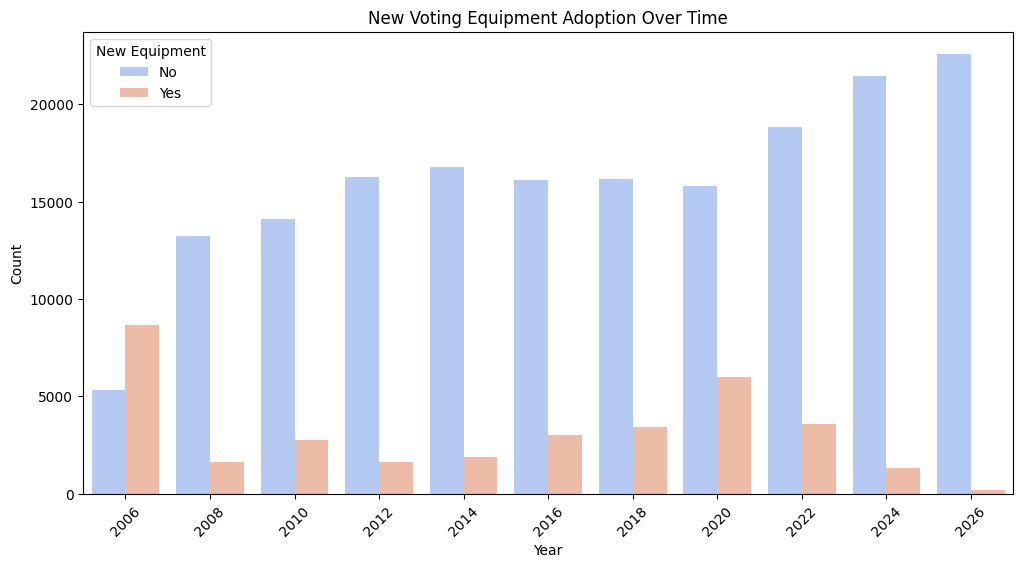

In [ ]:

# Plot the number of new equipment instances over time
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='New Equipment', data=df.dropna(subset=['New Equipment']), palette='coolwarm')
plt.title('New Voting Equipment Adoption Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='New Equipment', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

# todo: make this for each of the equipment types

In [53]:
df['New Equipment']

0          True
1         False
2          <NA>
3          True
4         False
          ...  
279745    False
279746     <NA>
279747    False
279748    False
279749     <NA>
Name: New Equipment, Length: 279750, dtype: object

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_30787/3774886008.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')


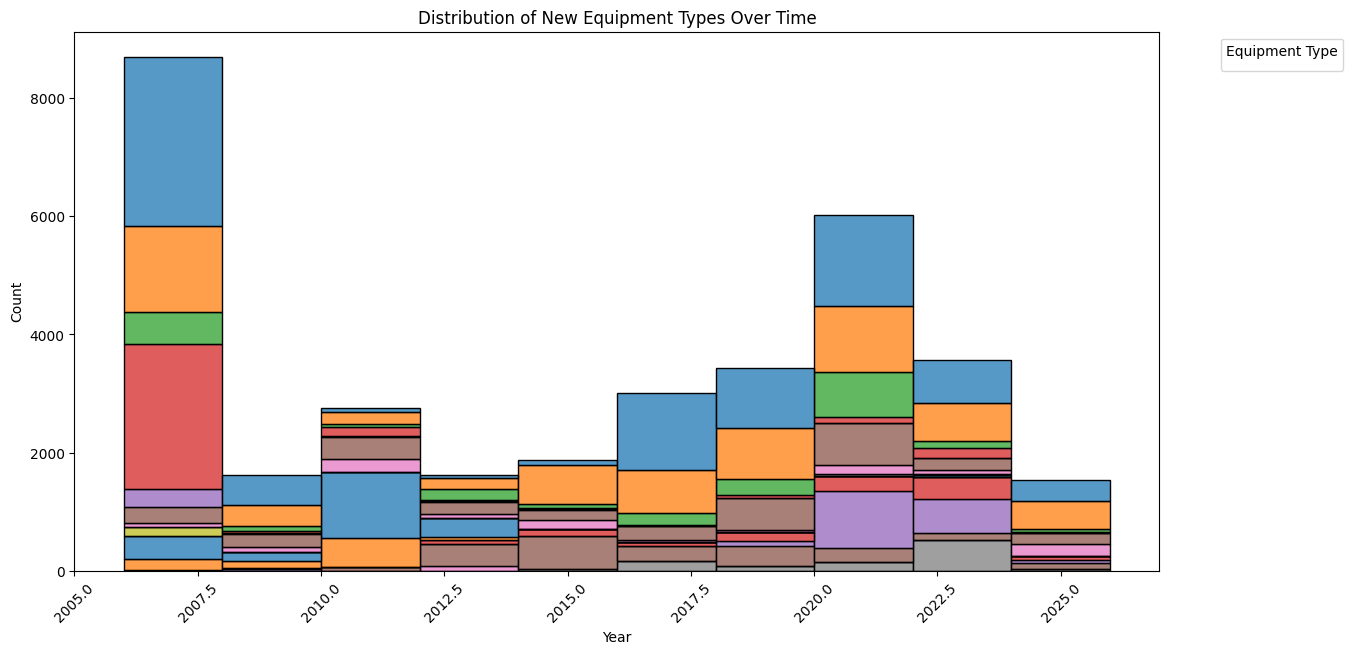

In [ ]:

# Plot new equipment trends by Equipment Type
plt.figure(figsize=(14, 7))
sns.histplot(data=df[df['New Equipment']==True], x='Year', hue='Equipment Type', multiple='stack', palette='tab10', bins=10)
plt.title('Distribution of New Equipment Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# todo: make legend, improve x-axis by year

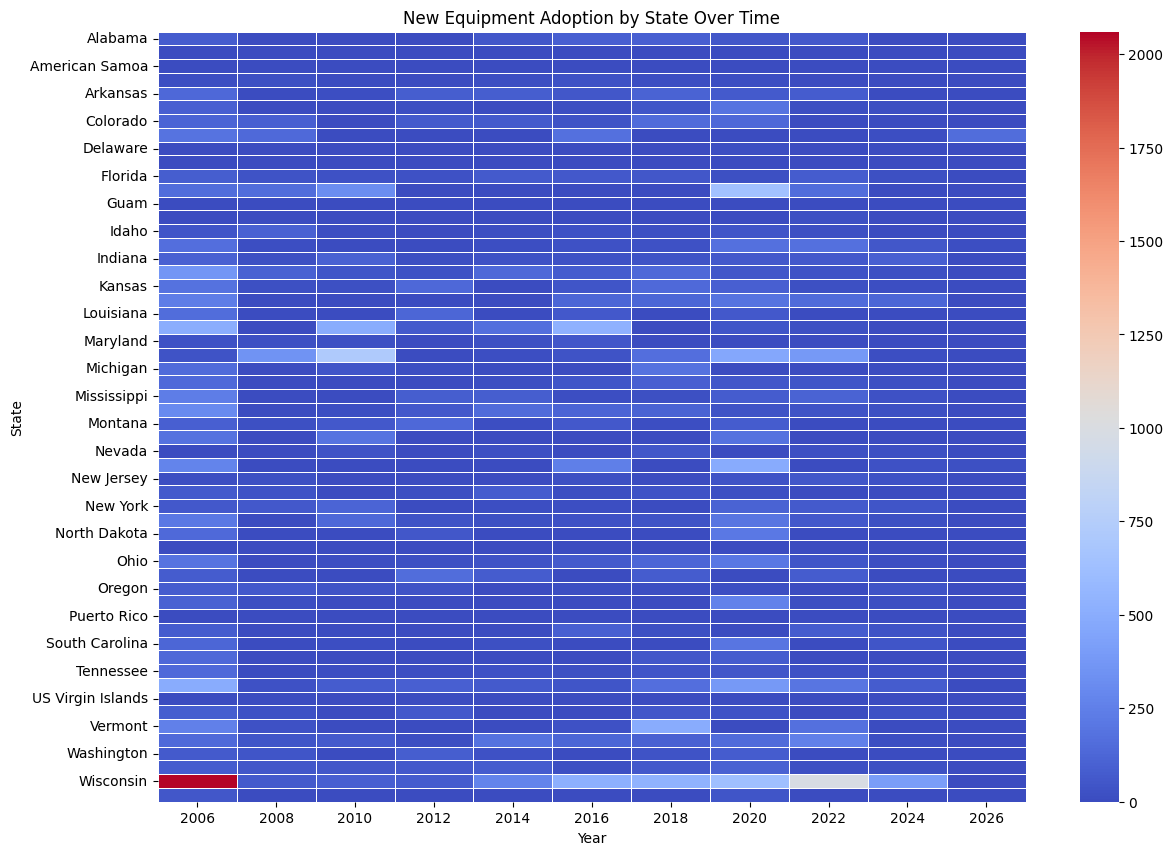

Year
2006    0
2008    0
2010    0
2012    0
2014    0
2016    0
2018    0
2020    0
2022    0
2024    0
2026    0
Name: New Equipment, dtype: int64


In [ ]:

df['is_new'] = df['New Equipment']==True # this is prob not necessary
# Summary stats
distribution_by_state = df.groupby(['State', 'Year'])['is_new'].sum().reset_index()
distribution_by_state_pivot = distribution_by_state.pivot(index='State', columns='Year', values='is_new').fillna(0)

# Heatmap of new equipment adoption by state
plt.figure(figsize=(14, 10))
sns.heatmap(distribution_by_state_pivot, cmap='coolwarm', linewidths=0.5)
plt.title('New Equipment Adoption by State Over Time')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

# Display summary of new equipment per year
print(df_filtered.groupby('Year')['New Equipment'].sum())

# todo: think about if something like this is useful at all

/Users/will/Repos/voting-equipment/data/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/will/Repos/voting-equipment/data/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/will/Repos/voting-equipment/data/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/will/Repos/voting-equipment/data/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enoug

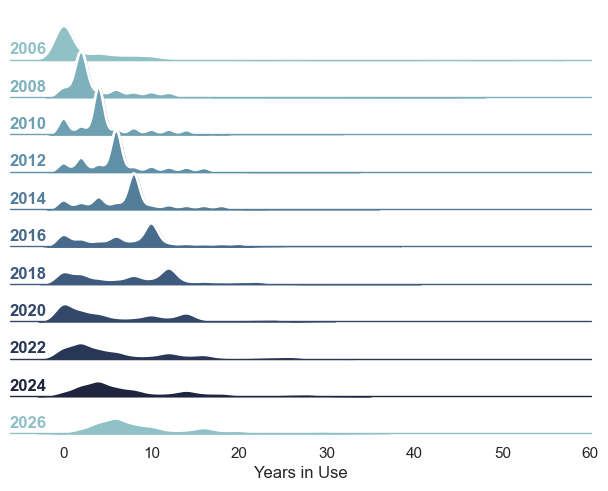

In [ ]:
# using sample seaborn code https://seaborn.pydata.org/examples/kde_ridgeplot

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Year", hue="Year", aspect=15, height=.5, palette=pal)

bw_adjust = 1

g.map(sns.kdeplot, "Years in Use",
      bw_adjust=bw_adjust, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Years in Use", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)


# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    


g.map(label, "Years in Use")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
